<br/>
<img src="https://i.imgur.com/kCNAFTN.jpg?1" title="source: imgur.com" />

#  District X's Houses

# Outline: 
  1. **Importing & Initial Data Exploration**
  2. **Data Preprocessing & EDA**
  3. **Modeling**
  4. **Hyperparameter Tuning**
  5. **Evaluating**
  6. **Conclusion**

# 1. Importing & Initial Data Exploration

## 1.1. Importing Data 

In [1]:
import math
import numpy as np
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sklearn
import category_encoders as ce
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble
from sklearn import model_selection
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from scipy import stats
from sklearn.model_selection import cross_val_score
import scipy
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import norm
from mpl_toolkits.mplot3d import Axes3D
import folium
from folium.plugins import HeatMap
from pandas import option_context
from scipy.stats import norm, skew
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

In [2]:
url = 'https://raw.githubusercontent.com/trangmx/fdc104/main/datasets/distict_x_houses/District_X_Houses.csv'
data = pd.read_csv(url)

In [3]:
data.head()

,Median_House_Value,Median_Income,Median_Age,Tot_Rooms,Tot_Bedrooms,Population,Households,Latitude,Longitude,Distance_to_coast,Distance_to_LA,Distance_to_SanDiego,Distance_to_SanJose,Distance_to_SanFrancisco
0,452600.0,8.3252,41,880,129,322,126,37.88,-122.23,9263.040773,556529.158342,735501.806984,67432.517001,21250.213767
1,358500.0,8.3014,21,7099,1106,2401,1138,37.86,-122.22,10225.733072,554279.850069,733236.884360,65049.908574,20880.600400
2,352100.0,7.2574,52,1467,190,496,177,37.85,-122.24,8259.085109,554610.717069,733525.682937,64867.289833,18811.487450
3,341300.0,5.6431,52,1274,235,558,219,37.85,-122.25,7768.086571,555194.266086,734095.290744,65287.138412,18031.047568
4,342200.0,3.8462,52,1627,280,565,259,37.85,-122.25,7768.086571,555194.266086,734095.290744,65287.138412,18031.047568


In [4]:
data.shape

(20640, 14)

In [5]:
data.dtypes

Median_House_Value          float64
Median_Income               float64
Median_Age                    int64
Tot_Rooms                     int64
Tot_Bedrooms                  int64
Population                    int64
Households                    int64
Latitude                    float64
Longitude                   float64
Distance_to_coast           float64
Distance_to_LA              float64
Distance_to_SanDiego        float64
Distance_to_SanJose         float64
Distance_to_SanFrancisco    float64
dtype: object

**Tất cả các features đều có định dạng đúng**

### Missing Value

In [6]:
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
Median_House_Value,0,0.0
Median_Income,0,0.0
Median_Age,0,0.0
Tot_Rooms,0,0.0
Tot_Bedrooms,0,0.0
Population,0,0.0
Households,0,0.0
Latitude,0,0.0
Longitude,0,0.0
Distance_to_coast,0,0.0


**Bộ dữ liệu không có missing value**

## 1.2. Initial Data Exploration

### Definitions and expectation:

In [7]:
features = {
    'feature': ['Median_House_Value', 'Median_Income', 'Median_Age', 'Tot_Rooms/ Tot_Bedrooms', 'Population/ Households', 'Latitude + Longitude', 'Distance to coast', 'Distance to city_X'],
    'definition': ['Giá nhà trung vị trong block (Target Variable)', 'Thu nhập trung vị của các hộ gia đình trong block', 'Tuổi trung vị của các căn nhà trong block', 'Tổng số phòng/ phòng ngủ của các căn nhà trong block', 'Tổng số cư dân/ hộ gia đình trong block', 'Vị trí địa lý của căn nhà', 'Khoảng cách tới bờ biển gần nhất', 'Khoảng cách tới các thành phố lớn'],
    'expectation': ['', 'Tại Mỹ, tỷ lệ giá nhà/ trung vị thu nhập ~ 5 giai đoạn 2010-2019 (+)', 'Chất lượng của căn nhà sẽ giảm dần theo thời gian (-)', 'Căn nhà có nhiều phòng thường có diện tích, độ tiện nghi cao hơn (+)', 'Chưa xác định (+/-)', 'Chưa xác định (+/-)', 'Các ngôi nhà gần biển có giá trị lớn về mặt du lịch, kinh tế,... (-)', 'Gần thành phố lớn đảm bảo giáo dục, y tế,... tốt hơn, tiết kiệm chi phí đi lại (-)']
}
definition = pd.DataFrame(features)
with option_context('display.max_colwidth', 600):
    display(definition)

,feature,definition,expectation
0,Median_House_Value,Giá nhà trung vị trong block (Target Variable),
1,Median_Income,Thu nhập trung vị của các hộ gia đình trong block,"Tại Mỹ, tỷ lệ giá nhà/ trung vị thu nhập ~ 5 giai đoạn 2010-2019 (+)"
2,Median_Age,Tuổi trung vị của các căn nhà trong block,Chất lượng của căn nhà sẽ giảm dần theo thời gian (-)
3,Tot_Rooms/ Tot_Bedrooms,Tổng số phòng/ phòng ngủ của các căn nhà trong block,"Căn nhà có nhiều phòng thường có diện tích, độ tiện nghi cao hơn (+)"
4,Population/ Households,Tổng số cư dân/ hộ gia đình trong block,Chưa xác định (+/-)
5,Latitude + Longitude,Vị trí địa lý của căn nhà,Chưa xác định (+/-)
6,Distance to coast,Khoảng cách tới bờ biển gần nhất,"Các ngôi nhà gần biển có giá trị lớn về mặt du lịch, kinh tế,... (-)"
7,Distance to city_X,Khoảng cách tới các thành phố lớn,"Gần thành phố lớn đảm bảo giáo dục, y tế,... tốt hơn, tiết kiệm chi phí đi lại (-)"


### 1.2.1. Median_House_Value

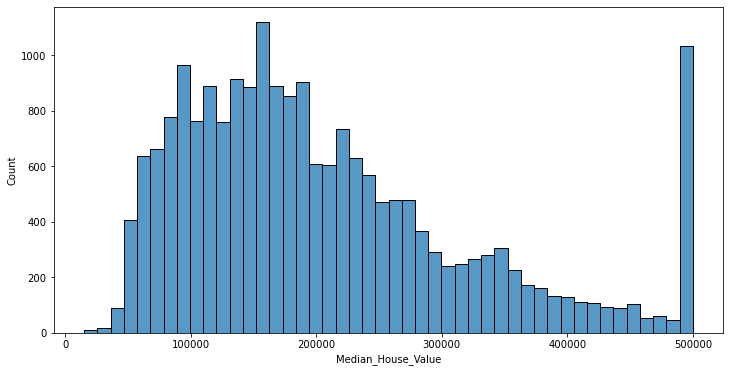

In [8]:
plt.figure(figsize = (12,6))
sns.histplot(x = data['Median_House_Value'])
plt.show()

In [9]:
#skewness and kurtosis
print("Skewness: %f" % data['Median_House_Value'].skew())
print("Kurtosis: %f" % data['Median_House_Value'].kurt())

Skewness: 0.977763
Kurtosis: 0.327870


**Nhận xét:**
* Giá nhà trung vị của block phân bổ không đồng đều với Skewness và Kurtosis thấp (0.98, 0.33 - lệch trái và bề ngang rộng)
* 160000 và 500000 là những giá có tần suất xuát hiện nhiều nhất

### 1.2.2. Median_Age

**Chia Median_Age theo các 3 bins: New, Normal, Old:**

In [10]:
data['Median_Age'] = pd.cut(data['Median_Age'], bins= np.linspace(0, max(data["Median_Age"]), 4), labels=['New','Normal','Old'])

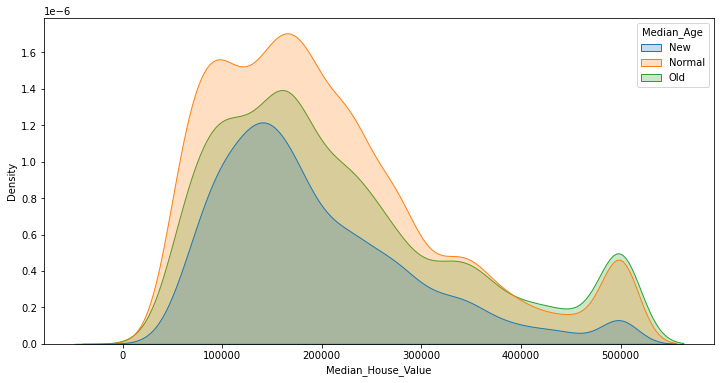

In [11]:
plt.figure(figsize = (12,6))
sns.kdeplot(x = 'Median_House_Value', shade = 'blue', hue = 'Median_Age', data =data, )
plt.show()

**Nhận xét:**
* Số lượng nhà có tuổi thọ được phân loại Old và Normal tương đối nhiều do 50% căn nhà ở Mỹ được xây dựng trước năm 1980
* Điểm thú vị của bộ dữ liệu: Những căn nhà có tuổi thọ càng lâu đời thì giá trung vị có xu hướng cao hơn so với những căn nhà mới.
* Với đặc điểm của bộ dữ liệu, tuổi thọ trung vị của căn nhà trong block không có ảnh hưởng rõ rệt đến giá của căn nhà trong block. 

### 1.2.3. Median_Income

<AxesSubplot:xlabel='Median_Income', ylabel='Median_House_Value'>

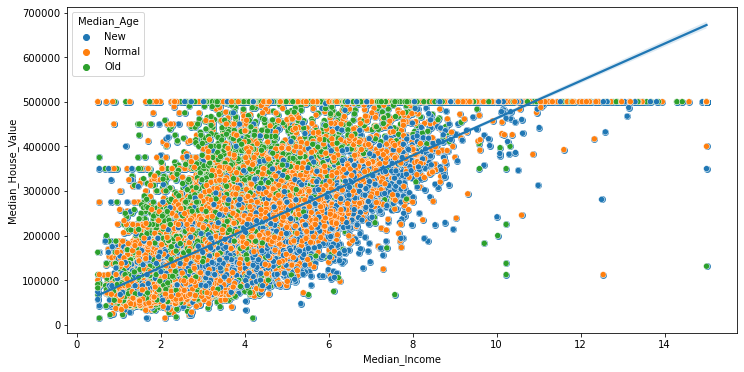

In [12]:
plt.figure(figsize = (12,6))
sns.regplot(x = 'Median_Income', y = 'Median_House_Value', data = data)
sns.scatterplot(x = 'Median_Income', y = 'Median_House_Value', hue = 'Median_Age', data= data)

**Nhận xét:**
* Median_Income và Median_House_Value có tương quan dương ở cả 3 nhóm nhà
* Tuy nhiên, có tương đối nhiều Outliers (Median_Income cao mà Median_House_Value thấp hoặc ngược lại) do thói quen chi tiêu 

### 1.2.4. Tot_Rooms

<AxesSubplot:xlabel='Tot_Rooms', ylabel='Median_House_Value'>

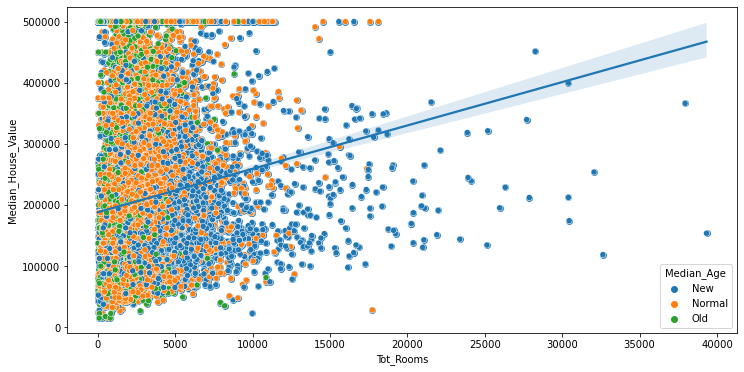

In [13]:
plt.figure(figsize = (12,6))
sns.regplot(x = 'Tot_Rooms', y = 'Median_House_Value', data = data)
sns.scatterplot(x = 'Tot_Rooms', y = 'Median_House_Value', hue = 'Median_Age', data= data)

**Nhận xét:**
* Số lượng phòng có tương quan dương với Median_House_Value
* Tuy nhiên, có tương đối nhiều trường hợp ngoại lệ (Nhiều phòng nhưng giá thấp hoặc ngược lại) do còn ảnh hưởng bởi nhiều yếu tố khác: Vị trí, Thu nhập,...

### 1.2.5. Tot_Bedrooms

<AxesSubplot:xlabel='Tot_Bedrooms', ylabel='Median_House_Value'>

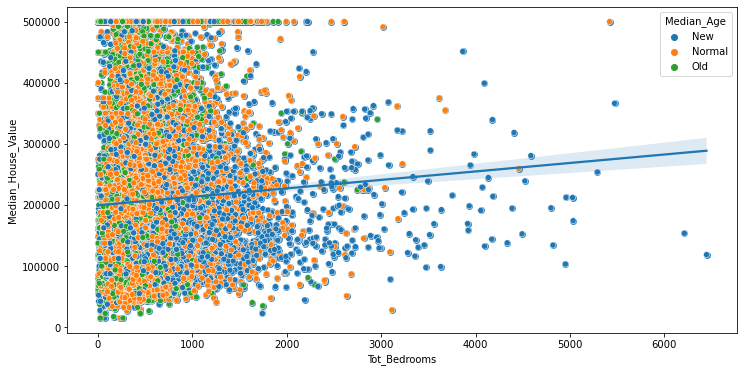

In [14]:
plt.figure(figsize = (12,6))
sns.regplot(x = 'Tot_Bedrooms', y = 'Median_House_Value', data = data)
sns.scatterplot(x = 'Tot_Bedrooms', y = 'Median_House_Value', hue = 'Median_Age', data= data)

**Nhận xét:**
* Không giống như Tot_Rooms, Tot_Bedrooms không có nhiều tác động đến Median_House Value

**Giải thích:**
* Trong khi các căn nhà có tuổi thọ cao và trung bình thường có ít phòng ngủ thì các căn nhà mới được xây dựng lại có nhiều phòng ngủ hơn. Tuy nhiên, chính các căn nhà cũ mới có giá cao.
* Như vậy, Tot_Bedrooms không phản ánh được Median_HouseValue.

### 1.2.6. Population/ Households 

<AxesSubplot:xlabel='Households', ylabel='Median_House_Value'>

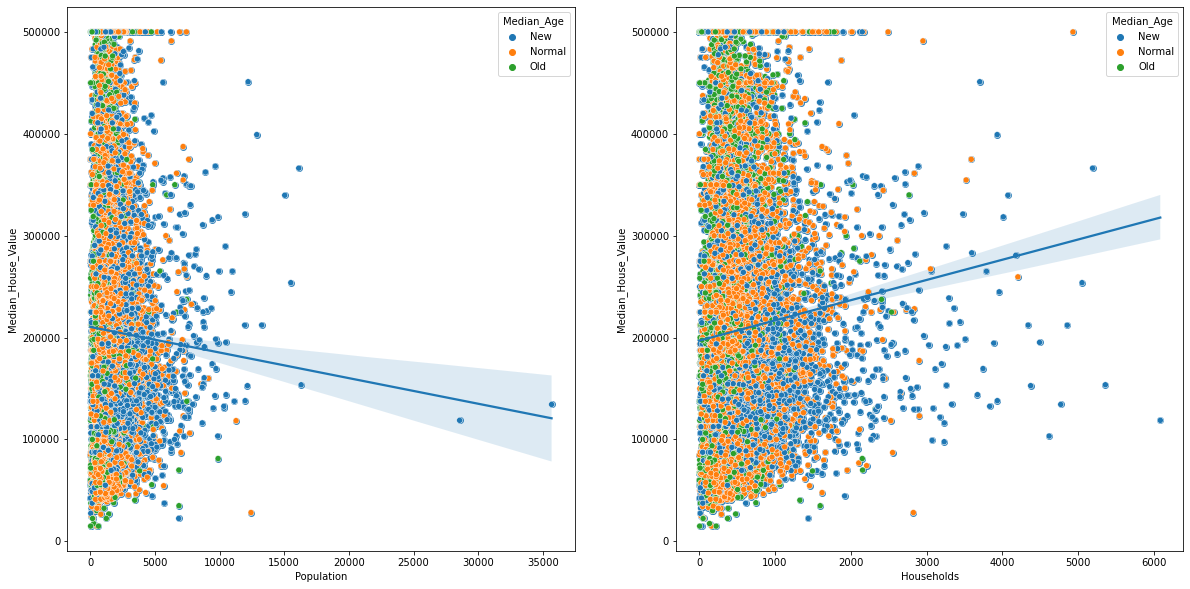

In [15]:
plt.figure(figsize = (20,10))

ax1 = plt.subplot(1,2,1)
sns.regplot(x = 'Population', y = 'Median_House_Value', data = data)
sns.scatterplot(x = 'Population', y = 'Median_House_Value', hue = 'Median_Age', data = data)

ax2 = plt.subplot(1,2,2)
sns.regplot(x = 'Households', y = 'Median_House_Value', data = data)
sns.scatterplot(x = 'Households', y = 'Median_House_Value', hue = 'Median_Age', data = data)

**Nhận xét:**
* Households và Population có những tương quan trái ngược với Median_House_Value (không hợp lý)
* Các ngôi nhà có tuổi thọ cũ thì thường tập trung ở khu vực ít dân cư trong khi các ngôi nhà mới thường tập trung ở các khu vực đông dân cư hơn 

### 1.2.7. Ladtitude + Longitude

In [16]:
# find the row of the house which has the highest price
maxpr=data.loc[data['Median_House_Value'].idxmax()]

# define a function to draw a basemap easily
def generateBaseMap(default_location=[47.5112, -122.257], default_zoom_start=9.4):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

data_copy = data.copy()
# select a zipcode for the heatmap
#set(df['zipcode'])
#df_copy = df[df['zipcode']==98001].copy()
data_copy['count'] = 1
basemap = generateBaseMap()
# add carton position map
folium.TileLayer('cartodbpositron').add_to(basemap)
s=folium.FeatureGroup(name='icon').add_to(basemap)
# add a marker for the house which has the highest price
folium.Marker([maxpr['Latitude'], maxpr['Longitude']],popup='Highest Price: $'+str(format(maxpr['Median_House_Value'],'.0f')),
              icon=folium.Icon(color='green')).add_to(s)
# add heatmap
HeatMap(data=data_copy[['Latitude','Longitude','count']].groupby(['Latitude','Longitude']).sum().reset_index().values.tolist(),
        radius=8,max_zoom=13,name='Heat Map').add_to(basemap)
folium.LayerControl(collapsed=False).add_to(basemap)
basemap

**Nhận xét:**
* Các căn nhà trong bộ dữ liệu thuộc bang California
* Mật độ của các căn nhà tương đối đồng đều trên toàn bang California, trong đó Los Angeles có mật độ nhà đông đúc nhất

### 1.2.8. Distance_to_coast

<AxesSubplot:xlabel='Distance_to_coast', ylabel='Median_House_Value'>

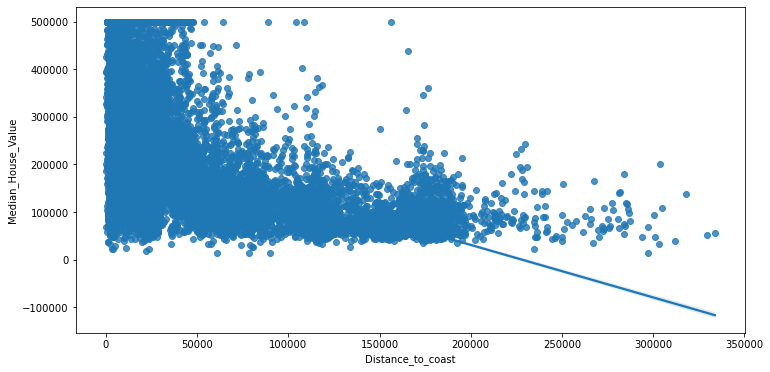

In [17]:
plt.figure(figsize = (12,6))
sns.regplot(x = 'Distance_to_coast', y = 'Median_House_Value', data = data)

**Nhận xét:**
* Các căn nhà có vị trí gần bở biển giá có xu hướng cao hơn các căn nhà ở xa bờ biển

### 1.2.9. Distance_to_cityX

* *San Francisco, San Jose, LA và San Diego là 4 thành phố lớn nhất của bang California*
* *Cả 4 thành phố đều thuộc TOP 20 thành phố giàu nhất nước Mỹ*

<AxesSubplot:xlabel='Distance_to_LA', ylabel='Median_House_Value'>

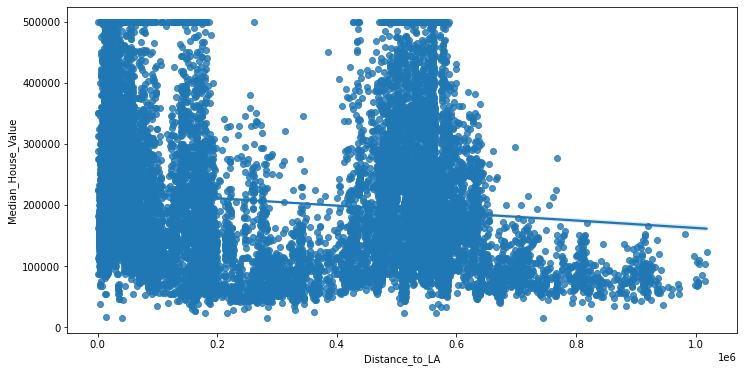

In [18]:
plt.figure(figsize = (12,6))
sns.regplot(x = 'Distance_to_LA', y = 'Median_House_Value', data = data)

**Nhận xét:**
* Các căn nhà có vị trí gần thành phố LA thì giá càng cao
* Ngoài ra, nhóm còn phát hiện các điểm tuy không gần LA nhưng vẫn có giá cao:
    * Cách LA 200000m: các căn nhà có giá cao vì ở gần bở biển (18000 m) hoặc gần San Diego (193000m)
    * Cách LA 400000-600000m: các căn nhà có giá cao vì ở khu vực San Francisco (610000m) hoặc San Jose (540000m)
* Các căn nhà có giá cao nhất (~500000$) đều nằm ở các thành phố lớn hoặc ở gần bờ biển


**Điều tương tự với các thành phố còn lại**

<AxesSubplot:xlabel='Distance_to_SanFrancisco', ylabel='Median_House_Value'>

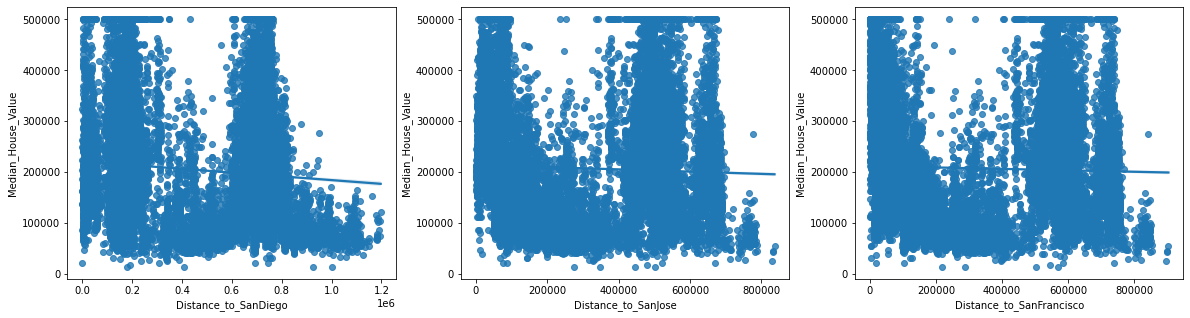

In [19]:
plt.figure(figsize = (20,5))
ax1 = plt.subplot(1,3,1)
sns.regplot(x = 'Distance_to_SanDiego', y = 'Median_House_Value', data = data)
ax2 = plt.subplot(1,3,2)
sns.regplot(x = 'Distance_to_SanJose', y = 'Median_House_Value', data = data)
ax3 = plt.subplot(1,3,3)
sns.regplot(x = 'Distance_to_SanFrancisco', y = 'Median_House_Value', data = data)

# 2. Data Preprocessing & EDA

In [20]:
dataset = data.copy()

## 2.1. Data Preprocessing

### 2.1.1. Outliers

In [21]:
#Function tìm kiếm outliers của từng trường 
def Zscore_outlier(df):
    out= {df: 0}
    m = np.mean(dataset[df])
    sd = np.std(dataset[df])
    for i in dataset[df]: 
        z = (i-m)/sd
        if np.abs(z) > 2.0: #Nhóm định nghĩa Outliers có z-score > 2.0
            out[df] += 1
    return out

#Các outliers ứng với từng features:
numeric_cols = [col for col in dataset.columns if dataset[col].dtype != 'category']
for col in numeric_cols:
    print(Zscore_outlier(col))

{'Median_House_Value': 1383}
{'Median_Income': 851}
{'Tot_Rooms': 742}
{'Tot_Bedrooms': 816}
{'Population': 756}
{'Households': 813}
{'Latitude': 429}
{'Longitude': 262}
{'Distance_to_coast': 1604}
{'Distance_to_LA': 389}
{'Distance_to_SanDiego': 321}
{'Distance_to_SanJose': 8}
{'Distance_to_SanFrancisco': 4}


**Số lượng Outliers của từng trường tương đối lớn nên nhóm quyết định sẽ sử dụng các kĩ thuật để xử lý các Outliers này**

C:\Users\hiep0\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\hiep0\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


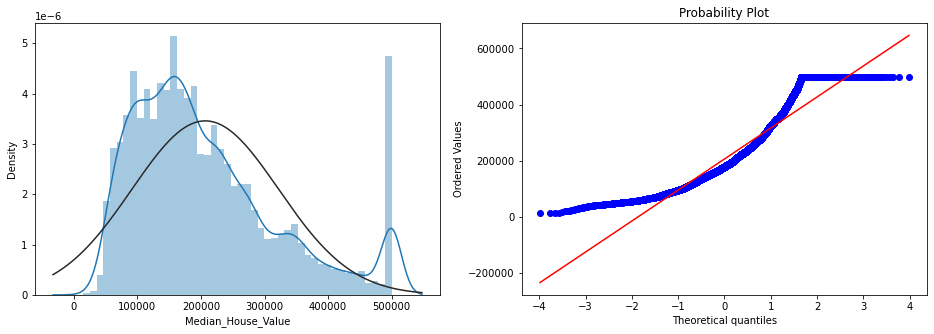

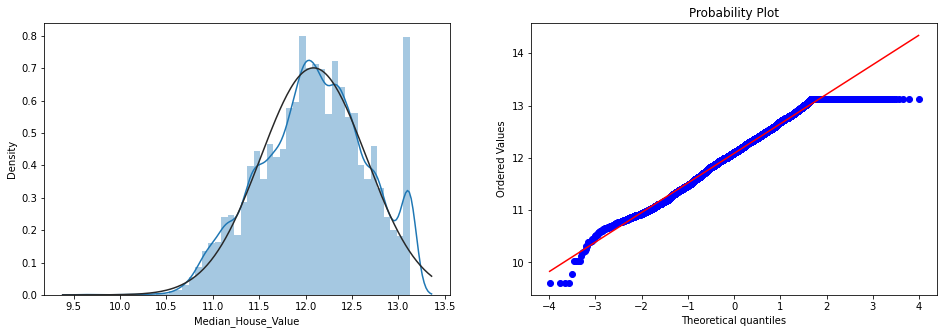

In [22]:
#histogram and normal probability plot
plt.figure(figsize = (16,5))
ax1 = plt.subplot(1,2,1)
sns.distplot(dataset['Median_House_Value'], fit=norm);
ax2 = plt.subplot(1,2,2)
res = stats.probplot(dataset['Median_House_Value'], plot=plt);

#applying log transformation
dataset['Median_House_Value'] = np.log(dataset['Median_House_Value']);

plt.figure(figsize = (16,5))
ax3 = plt.subplot(1,2,1)
sns.distplot(dataset['Median_House_Value'], fit=norm);
ax4 = plt.subplot(1,2,2)
res = stats.probplot(dataset['Median_House_Value'], plot=plt)

### 2.1.2. Skewness

**Do hầu hết các biến có skewness dương nên nhóm sử dụng Box-Cox Transformation để đưa các biến về phân phối thông thường và xử lý các Outliers**

In [23]:
dataset_Median_Age = dataset.pop('Median_Age')

In [24]:
skewed_feats = dataset.apply(lambda x: skew(x))
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)

,Skew
Median_House_Value,-0.173163
Median_Income,1.646537
Tot_Rooms,4.147042
Tot_Bedrooms,3.452822
Population,4.935500
Households,3.410190
Latitude,0.465919
Longitude,-0.297780
Distance_to_coast,1.938568
Distance_to_LA,0.466502


In [25]:
skewness_condition = abs(skewness) > 0.75
skewness = skewness[skewness_condition]
skewness.dropna(inplace = True)
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    dataset[feat] = boxcox1p(dataset[feat], lam)

There are 6 skewed numerical features to Box Cox transform


C:\Users\hiep0\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\hiep0\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\hiep0\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

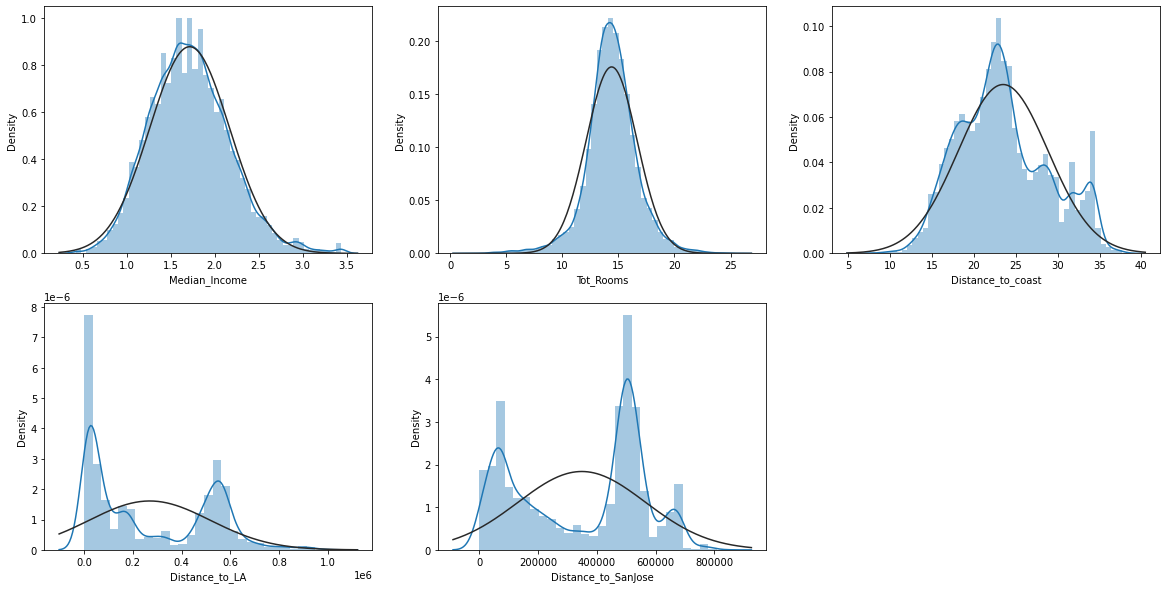

In [26]:
plt.figure(figsize = (20,10))
ax1 = plt.subplot(2,3,1)
sns.distplot(dataset['Median_Income'], fit=norm);
ax2 = plt.subplot(2,3,2)
sns.distplot(dataset['Tot_Rooms'], fit=norm);
ax3 = plt.subplot(2,3,3)
sns.distplot(dataset['Distance_to_coast'], fit=norm);
ax4 = plt.subplot(2,3,4)
sns.distplot(dataset['Distance_to_LA'], fit=norm);
ax5 = plt.subplot(2,3,5)
sns.distplot(dataset['Distance_to_SanJose'], fit=norm);

## 2.2. EDA

### Mutual Information

In [27]:
dataset = pd.concat([dataset, dataset_Median_Age], axis = 1)
X = dataset.copy()
y = X.pop('Median_House_Value')

def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

make_mi_scores(X,y)

Distance_to_SanFrancisco    0.425883
Distance_to_SanJose         0.421875
Longitude                   0.396334
Median_Income               0.387720
Distance_to_SanDiego        0.376175
Distance_to_LA              0.369494
Latitude                    0.362080
Distance_to_coast           0.319422
Tot_Rooms                   0.035230
Households                  0.026634
Tot_Bedrooms                0.017959
Population                  0.017648
Median_Age                  0.014594
Name: MI Scores, dtype: float64

## Kết hợp MI với các phân tích ở phần EDA, các biến độc lập có ý nghĩa với target variable là:
1. **Median_Income**
2. **Tot_Rooms**
3. **Distance_to_coast**
4. **Distance_to_LA**
5. **Distance_to_SanDiego**
6. **Distance_to_SanFrancisco**
7. **Distance_to_SanJose**

## Correlation

In [28]:
dataset = dataset[['Median_House_Value', 'Median_Income', 'Tot_Rooms', 'Distance_to_coast', 'Distance_to_LA', 'Distance_to_SanDiego', 'Distance_to_SanFrancisco', 'Distance_to_SanJose']]

corr = dataset.corr()
corr.style.background_gradient(cmap = 'coolwarm').set_precision(2)

C:\Users\hiep0\AppData\Local\Temp\ipykernel_30708\6687096.py:4: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap = 'coolwarm').set_precision(2)


,Median_House_Value,Median_Income,Tot_Rooms,Distance_to_coast,Distance_to_LA,Distance_to_SanDiego,Distance_to_SanFrancisco,Distance_to_SanJose
Median_House_Value,1.00,0.68,0.19,-0.56,-0.17,-0.14,-0.01,-0.02
Median_Income,0.68,1.00,0.25,-0.24,-0.07,-0.06,-0.02,-0.04
Tot_Rooms,0.19,0.25,1.00,0.00,-0.02,-0.04,0.03,0.03
Distance_to_coast,-0.56,-0.24,0.00,1.00,0.09,0.12,0.02,-0.00
Distance_to_LA,-0.17,-0.07,-0.02,0.09,1.00,0.95,-0.85,-0.79
Distance_to_SanDiego,-0.14,-0.06,-0.04,0.12,0.95,1.00,-0.93,-0.89
Distance_to_SanFrancisco,-0.01,-0.02,0.03,0.02,-0.85,-0.93,1.00,0.99
Distance_to_SanJose,-0.02,-0.04,0.03,-0.00,-0.79,-0.89,0.99,1.00


**Ta có thể thấy một vài trường có tương quan cao với nhau:**
* Distance_to_LA và Distance_to_SanDiego do 2 thành phố này tương đối gần nhau 
* Distance_to_SanFrancisco và Distance_to_SanJose (tương tự như trên)

**Như vậy, để tránh xảy ra hiện tượng multicollinearity (đa cộng tuyến), chúng ta sẽ bỏ đi biến Distance_to_SanDiego và Distance_to_SanFrancisco**

In [29]:
dataset.drop(labels = ['Distance_to_SanDiego', 'Distance_to_SanFrancisco'], axis = 1, inplace = True)

# 3. Modeling 

![](https://insightimi.files.wordpress.com/2020/07/on-de793_201909_g_20190830121038.gif)

### Chia dataset thành 3 phần: Train, Validation, Test Set

In [30]:
X = dataset.copy()
y = X.pop('Median_House_Value')

In [31]:
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, test_size = 0.15, random_state = 0)

### Normalization

#### Để train model tốt hơn nhóm normalize các features: Fit với tập Train_Valid rồi Transform trên cả Train_Valid và Test Set để tránh tình trạng Data Leakage

In [32]:
cols = X_train_valid.select_dtypes(np.number).columns
transformer = MinMaxScaler().fit(X_train_valid[cols])
X_train_valid[cols] = transformer.transform(X_train_valid[cols])
X_test[cols] = transformer.transform(X_test[cols])

In [33]:
def get_score(model):
    # Replace this body with your own code
    my_pipeline = Pipeline(steps = [('model', model(random_state = 0))])
    r2_scores = cross_val_score(my_pipeline, X_train_valid, y_train_valid, cv = 5, scoring = 'r2')
    rmse_scores = -1*cross_val_score(my_pipeline, X_train_valid, y_train_valid, cv = 5, scoring = 'neg_root_mean_squared_error')
    print('R-squared:', r2_scores.mean(),'\n' ,'Root Mean Squared Error:', rmse_scores.mean()) 

## 3.1. XGBRegressor

In [34]:
get_score(XGBRegressor)

R-squared: 0.8185158490259854 
 Root Mean Squared Error: 0.24267035040202103


## 3.2. RandomForestRegressor

In [35]:
get_score(RandomForestRegressor)

R-squared: 0.8172079122050159 
 Root Mean Squared Error: 0.243566002502893


## 3.3. LinearRegression

In [36]:
lf = LinearRegression()
print('R-squared:', cross_val_score(lf, X_train_valid, y_train_valid, cv = 5, scoring = 'r2').mean(), '\n','Root Mean Squared Error:', (-1*cross_val_score(lf, X_train_valid, y_train_valid, cv = 5, scoring = 'neg_root_mean_squared_error')).mean())

R-squared: 0.6661494775255523 
 Root Mean Squared Error: 0.32916820617724507


# 4. Hyperparameter Tuning 

## 4.1. XGBRegressor

In [37]:
xgb_parameters = {'n_estimators' :[100,200,300,400,500],
              'max_depth':[4,6,8,10,12],
              'learning_rate':[0.05,0.1,0.15,0.2]
             }

In [38]:
model_xgb = xgb.XGBRegressor(random_state = 0)

grid_xgb = GridSearchCV(estimator=model_xgb,
                        param_grid = xgb_parameters,
                        scoring='neg_root_mean_squared_error',
                        cv = 5,
                        n_jobs=-1)

grid_xgb.fit(X_train_valid, y_train_valid)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=0,
                                    reg_alpha=None, reg_lambda=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1, 0.15, 0.2],
                         'max_depth': [4, 6, 8, 10, 12],
                         'n_estimators': [100, 200, 300, 400, 500]},
             scoring='neg_root_mean_squared_error')

In [39]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_xgb.best_estimator_)
print("\n The best score across ALL searched params:\n",-1*grid_xgb.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_xgb.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=12, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

 The best score across ALL searched params:
 0.23236946700537367

 The best parameters across ALL searched params:
 {'learning_rate': 0.05, 'max_depth': 12, 'n_estimators': 500}


## 4.2. RandomForestRegressor

In [40]:
rf_parameters = {'n_estimators' :[100,200,300,400,500],
              'max_depth':[4,6,8,10,12],
                 'bootstrap': [True, False]
             }

In [41]:
model_rf =  RandomForestRegressor(random_state = 0)

grid_rf = GridSearchCV(estimator=model_rf,
                        param_grid = rf_parameters,
                        scoring='neg_root_mean_squared_error',
                        cv = 5,
                        n_jobs=-1)

grid_rf.fit(X_train_valid, y_train_valid)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=0), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [4, 6, 8, 10, 12],
                         'n_estimators': [100, 200, 300, 400, 500]},
             scoring='neg_root_mean_squared_error')

In [42]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_rf.best_estimator_)
print("\n The best score across ALL searched params:\n",-1*grid_rf.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_rf.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 RandomForestRegressor(max_depth=12, n_estimators=500, random_state=0)

 The best score across ALL searched params:
 0.24777182074814003

 The best parameters across ALL searched params:
 {'bootstrap': True, 'max_depth': 12, 'n_estimators': 500}


# 5. Evaluating

## 5.1. XGBRegressor

In [43]:
test_xgb = xgb.XGBRegressor(learning_rate = 0.05, max_depth = 12, n_estimators = 500, random_state = 0)
test_xgb.fit(X_train_valid, y_train_valid)
print('R-squared:', test_xgb.score(X_test, y_test))
print('Root Mean Squared Error:', math.sqrt(mean_squared_error(test_xgb.predict(X_test), y_test)))

R-squared: 0.8410993775415375
Root Mean Squared Error: 0.22530537329384556


## 5.2. RandomForestRegressor

In [44]:
test_rf = RandomForestRegressor(bootstrap = True, max_depth = 12, n_estimators = 500, random_state = 0)
test_rf.fit(X_train_valid, y_train_valid)
print('R-squared:', test_rf.score(X_test, y_test))
print('Root Mean Squared Error:', math.sqrt(mean_squared_error(test_rf.predict(X_test), y_test)))

R-squared: 0.8175396754331539
Root Mean Squared Error: 0.2414309657503062


## 5.3. LinearRegression

In [45]:
test_lf = LinearRegression()
test_lf.fit(X_train_valid, y_train_valid)
print('R-squared:', test_lf.score(X_test, y_test))
print('Root Mean Squared Error:', math.sqrt(mean_squared_error(test_lf.predict(X_test), y_test)))

R-squared: 0.6581126041118639
Root Mean Squared Error: 0.33048389099037734


## <font color='red'>Như vậy, XGBRegressor là mô hình tốt nhất trên cả 3 Set: Training, Validation, Test với R Squared = 84%, Root Mean Squared Error = 0.05.</font> 

# 6. Conclusion

* Mô hình đem lại kết quả tốt nhất là XGBRegressor với các hyperparameters: Learning_rate = 0.05, Max_depth = 12, N_estimators = 500

* Để cải thiện hơn nữa độ chính xác của dự đoán, dataset có thể thu thập thêm các thông tin liên quan đến thông tin cơ bản của căn nhà: 
    * Diện tích 
    * Kiểu nhà 
    * Khu vực lân cận
    * Tình trạng căn nhà

# Thank You!